In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')
from datetime import datetime
from datetime import datetime, timedelta, date

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from datetime import datetime

In [4]:
crypto = pd.read_csv('Bitcoin.csv')
crypto['Date']=pd.to_datetime(crypto['Date'], format="%Y/%m/%d")

In [5]:
crypto['Date'] = pd.to_datetime(crypto['Date'])
crypto = crypto.set_index('Date')

In [6]:
crypto.isnull().sum()

Currency               0
Closing Price (USD)    0
24h Open (USD)         0
24h High (USD)         0
24h Low (USD)          0
dtype: int64

In [7]:
crypto.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2665 entries, 2013-10-01 to 2021-02-25
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2665 non-null   object 
 1   Closing Price (USD)  2665 non-null   float64
 2   24h Open (USD)       2665 non-null   float64
 3   24h High (USD)       2665 non-null   float64
 4   24h Low (USD)        2665 non-null   float64
dtypes: float64(4), object(1)
memory usage: 124.9+ KB


In [8]:
crypto = crypto.drop(['Currency'],axis=1)

In [9]:
crypto['avg'] = (crypto['Closing Price (USD)'] + crypto['24h Open (USD)']+ crypto['24h High (USD)']+ crypto['24h Low (USD)'])/4

In [10]:
crypto.head()

,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD),avg
Date,,,,,
2013-10-01,123.65499,124.30466,124.75166,122.56349,123.818700
2013-10-02,125.45500,123.65499,125.75850,123.63383,124.625580
2013-10-03,108.58483,125.45500,125.66566,83.32833,110.758455
2013-10-04,118.67466,108.58483,118.67500,107.05816,113.248163
2013-10-05,121.33866,118.67466,121.93633,118.00566,119.988828


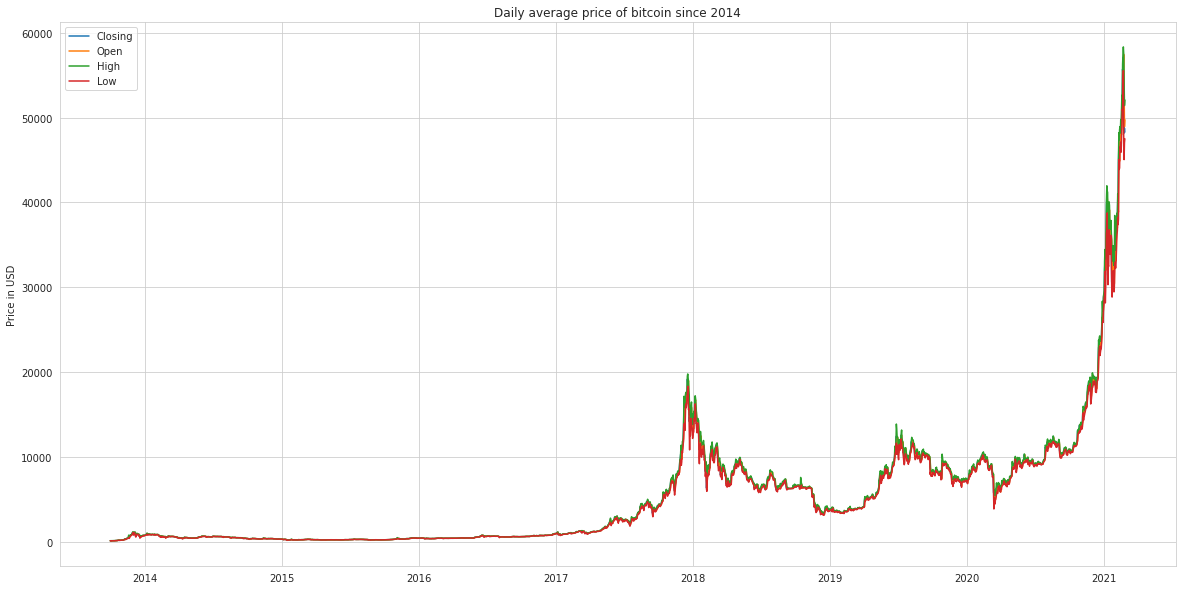

In [11]:
plt.figure(figsize=(20,10))
plt.plot(crypto[['Closing Price (USD)','24h Open (USD)', '24h High (USD)','24h Low (USD)' ]])
plt.ylabel('Price in USD')
plt.title('Daily average price of bitcoin since 2014')
plt.legend(['Closing','Open','High','Low'])

In [12]:
bitc = crypto[['Closing Price (USD)']]
bitc_ma = bitc.rolling(window=20).mean()

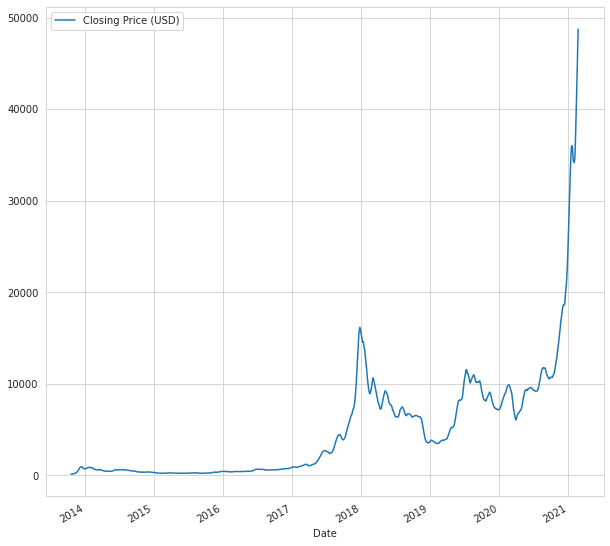

In [13]:
bitc_ma.plot(figsize=(10,10))

In [14]:
BTC = crypto.copy()

In [15]:
BTC['daily_avg_after_month']=BTC['avg'].shift(-30)
X_BTC = BTC.dropna().drop(['daily_avg_after_month','avg'],axis=1)
y_BTC = BTC.dropna()['daily_avg_after_month']
X_train_BTC, X_test_BTC, y_train_BTC, y_test_BTC = train_test_split(X_BTC, y_BTC, test_size=0.3, random_state=43)
X_forecast_BTC = BTC.tail(30).drop(['daily_avg_after_month','avg'],axis=1)

In [16]:
def regression(X_train, X_test, y_train, y_test):
    Regressor = {
        'ExtraTrees Regressor': ExtraTreesRegressor(n_estimators=500, min_samples_split=3),
        'Random Forest Regressor': RandomForestRegressor(n_estimators=200),
        'Bayesian Ridge': BayesianRidge(),
        'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=500),
         
    }

    for name, clf in Regressor.items():
        print(name)
        clf.fit(X_train, y_train)
    
        print(f'R2: {r2_score(y_test, clf.predict(X_test)):}')
        print(f'MAE: {mean_absolute_error(y_test, clf.predict(X_test)):}')
        print(f'MSE: {mean_squared_error(y_test, clf.predict(X_test)):}')
        print()

In [17]:
print ('Bitcoin')
regression(X_train_BTC, X_test_BTC, y_train_BTC, y_test_BTC)

Bitcoin
ExtraTrees Regressor
R2: 0.9197491097458472
MAE: 874.196598809864
MSE: 3633869.1556777027

Random Forest Regressor
R2: 0.916028747289407
MAE: 894.3788032180171
MSE: 3802332.2136647752

Bayesian Ridge
R2: 0.8848607558304662
MAE: 1255.795148799478
MSE: 5213661.140339327

Gradient Boosting Regressor
R2: 0.9025605964691019
MAE: 949.9458502009816
MSE: 4412188.349776476



In [18]:
def prediction (name, X, y, X_forecast):
    model = RandomForestRegressor(n_estimators=200)
    model.fit(X,y)
    target = model.predict(X_forecast)
    return target

In [19]:
forecast_BTC = prediction('btc',X_BTC, y_BTC, X_forecast_BTC)

In [20]:
last_date = max(crypto.index)
mod_date = last_date + timedelta(days=1)
new_date = pd.date_range(mod_date, periods=30, freq='D')

In [21]:
forecasted_BTC = pd.DataFrame(forecast_BTC, columns=['daily_avg'], index=new_date)

In [22]:
bitcoin = pd.concat([crypto[['avg']], forecasted_BTC])

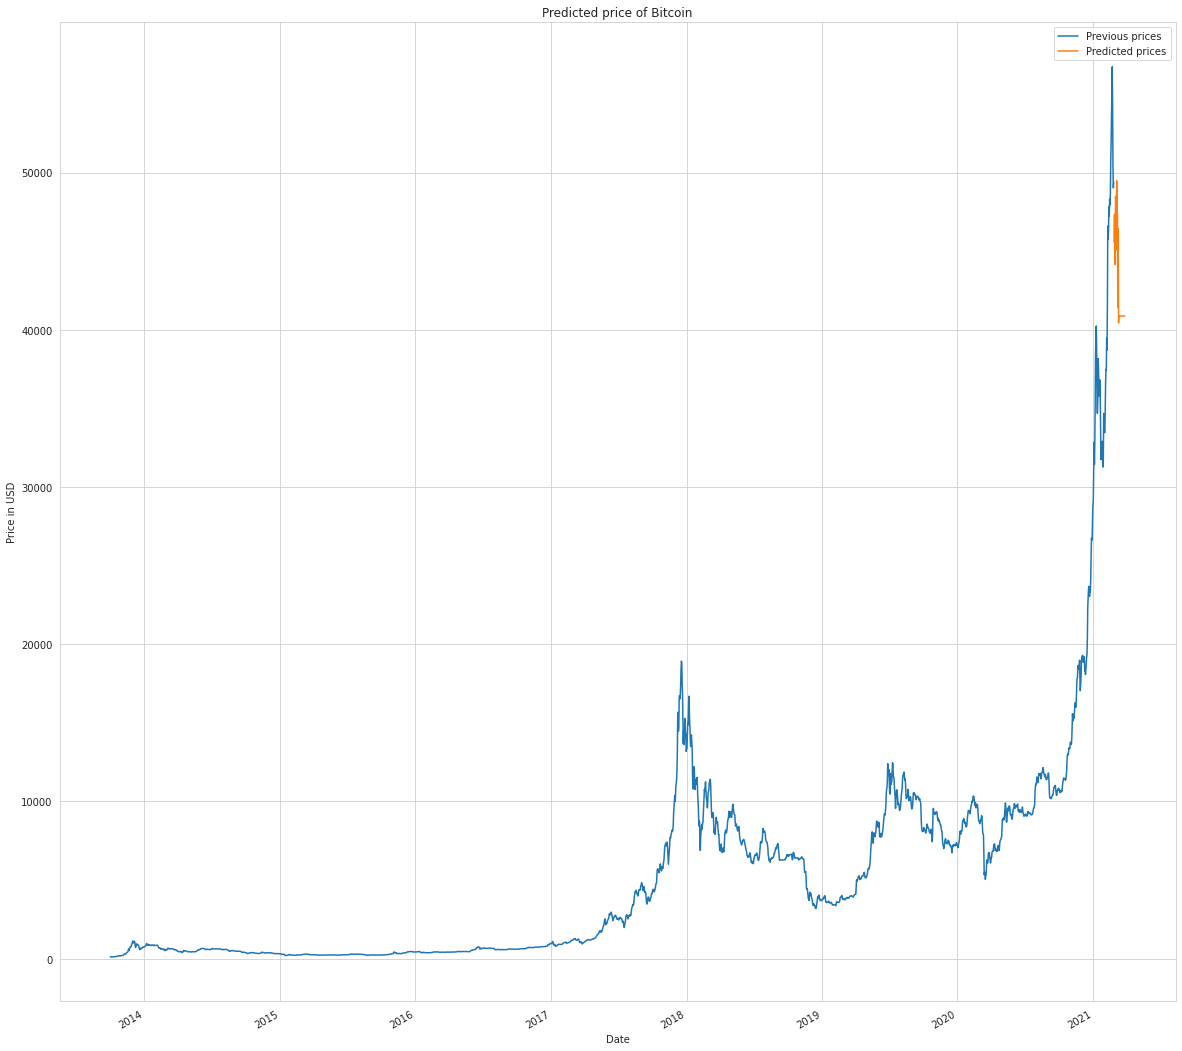

In [23]:
plt.figure(figsize=(20,20))
(bitcoin[:-30]['avg']).plot(label='Previous prices')
(bitcoin[-31:]['daily_avg']).plot(label='Predicted prices')

plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title ('Predicted price of Bitcoin')
plt.legend()
plt.show()

In [24]:
forecasted_BTC

,daily_avg
2021-02-26,45586.174282
2021-02-27,47335.067638
2021-02-28,44143.120136
2021-03-01,46409.264879
2021-03-02,48492.201636
2021-03-03,47814.244145
2021-03-04,45083.158093
2021-03-05,49475.126153
2021-03-06,47926.743921
2021-03-07,47350.790914
